# MedFollow: Medication Follow-Up Notebook

Prototype decision-support workflow. No diagnoses, prescriptions, or medical advice. When confidence is low, fall back to conservative recommendations and defer to clinicians.

## Dataset
- UCI Drug Reviews (Druglib.com), CC BY 4.0, research use only. Do not redistribute raw data beyond this project.
- Local path: `data/drug_reviews/data.csv`
- Fields: reviewID, urlDrugName, rating, effectiveness, sideEffects, condition, benefitsReview, sideEffectsReview, commentsReview.
- This dataset supports NLP + tabular modeling.

In [3]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
sns.set(style="whitegrid", context="talk")

In [ ]:
DATA_PATH = Path("data/drug_reviews/data.csv")
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
if not DATA_PATH.exists():
    try:
        import requests

        url = "https://archive.ics.uci.edu/static/public/461/data.csv"
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
        DATA_PATH.write_bytes(resp.content)
        print("Downloaded dataset from UCI archive.")
    except Exception:
        try:
            from ucimlrepo import fetch_ucirepo

            repo = fetch_ucirepo(id=461)
            repo.data["original"].to_csv(DATA_PATH, index=False)
            print("Fetched dataset via ucimlrepo.")
        except Exception as exc:
            raise RuntimeError(f"Dataset missing and download failed: {exc}")

raw_df = pd.read_csv(DATA_PATH)
text_cols = ["benefitsReview", "sideEffectsReview", "commentsReview"]
df = raw_df.dropna(subset=text_cols + ["effectiveness"]).copy()
df[text_cols] = df[text_cols].fillna("")
df["text"] = df[text_cols].agg(" ".join, axis=1)


def map_effectiveness(label: str) -> str:
    if label in {"Highly Effective", "Effective"}:
        return "effective"
    if label in {"Ineffective", "Marginally Effective"}:
        return "not_effective"
    return "mixed"


df["label_binary"] = df["effectiveness"].apply(map_effectiveness)
df = shuffle(df, random_state=SEED).reset_index(drop=True)
df[["label_binary", "effectiveness"]].value_counts()

Downloaded dataset from UCI archive.


label_binary   effectiveness         
effective      Highly Effective          1678
mixed          Considerably Effective    1209
               Moderately Effective       567
not_effective  Ineffective                310
               Marginally Effective       250
Name: count, dtype: int64

### Train and validation split
Stratified split on the binary label to keep class balance.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label_binary"],
    test_size=0.2,
    stratify=df["label_binary"],
    random_state=SEED,
)
len_train, len_test = len(X_train), len(X_test)
len_train, len_test

(3211, 803)

### Baseline pipeline
TF-IDF bigrams feeding a class-weighted Logistic Regression classifier.

In [6]:
pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.98,
                lowercase=True,
            ),
        ),
        (
            "logreg",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                solver="liblinear",
                n_jobs=-1,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)

C:\Users\Cyborg\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\Cyborg\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Evaluation
Reports, confusion matrix, and ROC-AUC on the held-out set.

               precision    recall  f1-score   support

    effective      0.643     0.676     0.659       336
        mixed      0.608     0.611     0.610       355
not_effective      0.495     0.411     0.449       112

     accuracy                          0.610       803
    macro avg      0.582     0.566     0.572       803
 weighted avg      0.607     0.610     0.608       803



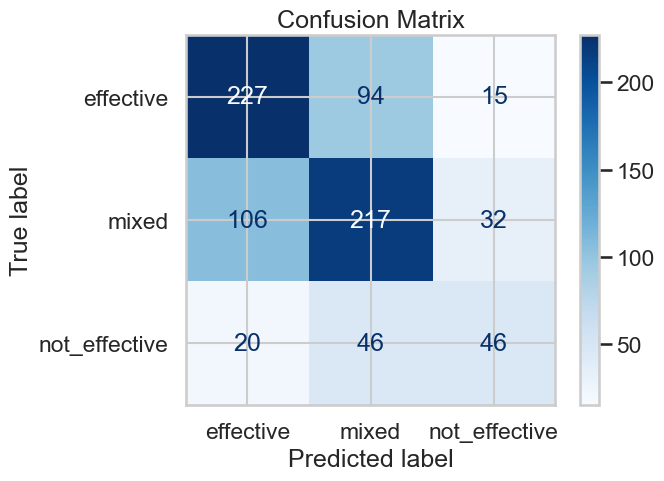

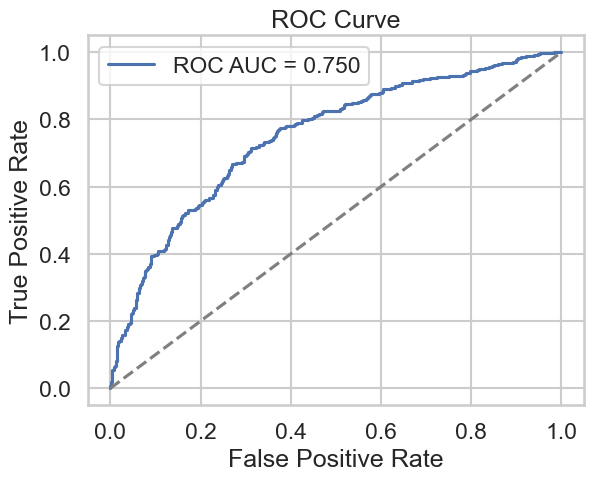

In [7]:
preds = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, list(pipeline.classes_).index("effective")]

print(classification_report(y_test, preds, digits=3))

cm = confusion_matrix(y_test, preds, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test.map(lambda x: 1 if x == "effective" else 0), probs)
roc_auc = roc_auc_score(y_test.map(lambda x: 1 if x == "effective" else 0), probs)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

### Retrieval and OOD checks
Simple similarity search for explainability and a coarse out-of-distribution guard based on TF-IDF cosine similarity.

In [8]:
tfidf = pipeline.named_steps["tfidf"]
train_vectors = tfidf.transform(X_train)


def retrieve_similar(query: str, k: int = 3):
    vec = tfidf.transform([query])
    sims = (train_vectors @ vec.T).toarray().ravel()
    top_idx = sims.argsort()[::-1][:k]
    top = X_train.iloc[top_idx]
    scores = sims[top_idx]
    return list(zip(top.index.tolist(), top.values.tolist(), scores.tolist()))


def ood_score(query: str) -> float:
    vec = tfidf.transform([query])
    sims = (train_vectors @ vec.T).toarray().ravel()
    return float(np.percentile(sims, 5))


sample_query = "Headache improved but new rash appeared after taking the medication"
retrieve_similar(sample_query, k=2), ood_score(sample_query)

([(2376,
   "Lessened the pain associated with the inflamation A red rash appeared every where on the body after two weeks ... Especially leg and hands..\r\n\r\nAfter taking showers, the rash was more marked... It was not itchy. Took Tramal for the first two weeks then switched to Tramada since the pharmacy didn't have anymore Tramal available.. Due to the apparition of rash the treatment was stopped on the suggestion of a skin doctor.",
   0.2916160183434362),
  (3432,
   'The skin rash was better I can not be sure it was from the medication but I had mild stomach upset I originally had lamisil cream to treat a  pretty bad case of ringworm.  After about 4 days the rash was spreading and so I went back and received oral Lamisil. I took that for 14 days and the rash was lighter but still there. The doctor then prescribed Ketoconazole and after 3 days the rash was significantly lighter. By the end of the prescription the rash was almost completely gone.',
   0.2372203624905018)],
 0.0026

### Decision wrapper
Combines model probability, OOD guard, and a simple symptom keyword check to output a conservative recommendation.

In [9]:
keywords_urgent = {
    "faint",
    "chest pain",
    "shortness of breath",
    "rash",
    "swelling",
    "bleeding",
}


def run_inference(text: str):
    prob_effective = pipeline.predict_proba([text])[0][
        list(pipeline.classes_).index("effective")
    ]
    ood = ood_score(text)
    has_urgent_term = any(term in text.lower() for term in keywords_urgent)
    decision = "schedule follow-up"
    if has_urgent_term:
        decision = "seek urgent medical advice"
    elif prob_effective >= 0.7 and ood >= 0.02:
        decision = "continue medication"
    elif prob_effective <= 0.35 or ood < 0.01:
        decision = "schedule follow-up"
    return {
        "prob_effective": float(prob_effective),
        "ood_score": float(ood),
        "decision": decision,
        "similar_cases": retrieve_similar(text, k=2),
    }


example = "Cough is slightly better but I have mild dizziness after each dose"
run_inference(example)

{'prob_effective': 0.25933622371064174,
 'ood_score': 0.0,
 'decision': 'schedule follow-up',
 'similar_cases': [(931,
   'The drug rapidly gets rid of migraine. The drug causes slight dizziness and tightness around my temples.  Sometimes I also feel slightly nauseated after taking it, but perhaps I should blame the headache and not the medication. I take one dose at onset of headache.  I repeat doses of the drug at one hour intervals if headache gets better but then worsens again.',
   0.18394266389608685),
  (2875,
   'The medicine kept the illness from getting worse, my cough loosened up immediately.  The dose and length of treatment was very managable, it was easy to remember to take one dose each day.  The packaging is very convenient - a blister pack so you know immediately how many you have taken. I experienced some mild stomach upset a few hours after taking the first dose (a combined dose totalling 500 mg.) 6 pills taken over 5 days - 2 pills first day, one each day after.',
 

## Next steps
- Add side-effect and rating heads (multitask or separate models).
- Swap in DistilBERT encoder with clear pretrained disclosure if GPU/Colab is available.
- Extend robustness checks (text perturbations) and document all thresholds.
- Add calibration plots and k-fold validation for stability.
- Integrate symptom change extraction instead of plain text concat.